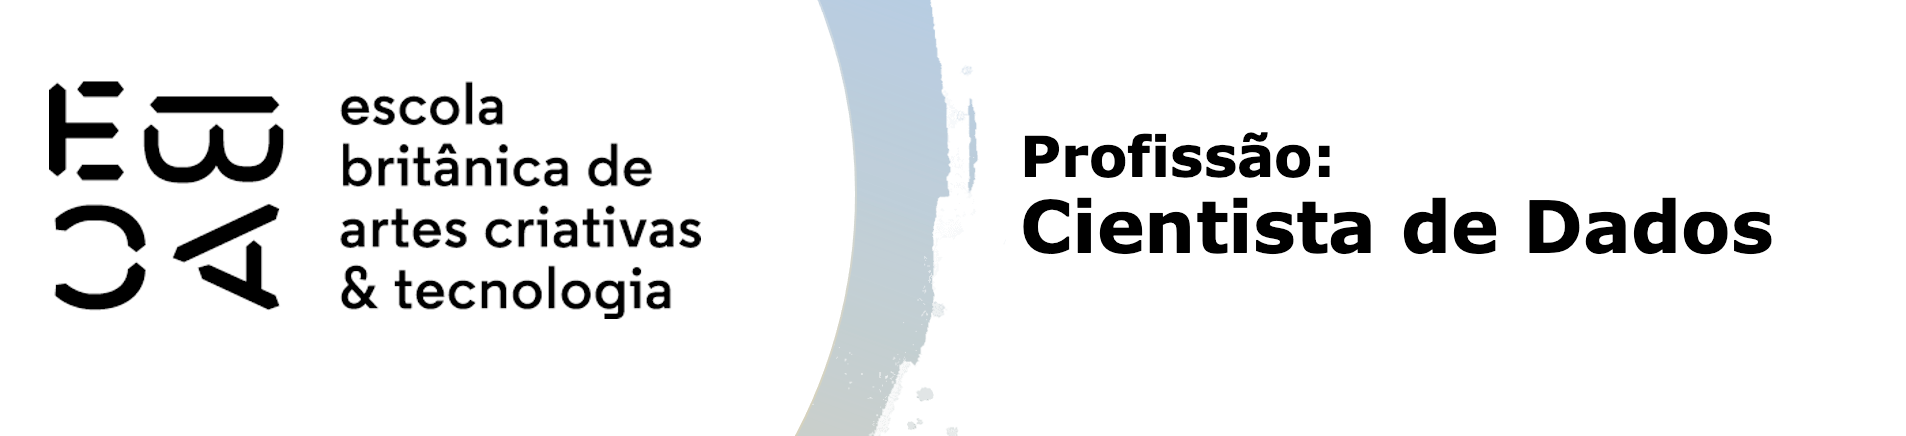

# Tarefa

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo é tentar agrupar os clientes conforme seu comportamento de navegação entre páginas administrativas, informativas e de produtos. 

As variáveis estão descritas abaixo (em tradução livre do link indicado).

Por este motivo, o escopo desta análise estará fechado nas primeiras seis variáveis da tabela, referentes a quantidade e tempo de acesso por tipo de página, atributos que falam mais do comportamento de navegação do cliente que de características da página o da época do ano.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')

In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
df.Revenue.value_counts(dropna=False)

False    10422
True      1908
Name: Revenue, dtype: int64

In [5]:
df.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [6]:
#Padronizando valores
X_train = df.select_dtypes(include="number")
X_pad = pd.DataFrame(StandardScaler().fit_transform(X_train),columns=X_train.columns)
y_train=df[['Revenue']]
X_pad = pd.concat([X_pad,y_train],axis=1)

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [7]:
dados=pd.concat([X_pad.iloc[:,:6],df['Revenue']],axis=1)
print(dados.shape)
dados.sample(5)

(12330, 7)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,Revenue
7209,-0.696993,-0.457191,5.114878,1.671083,-0.173844,-0.353208,False
4813,-0.696993,-0.457191,0.390859,0.465581,-0.421181,-0.433946,False
5242,-0.094882,-0.284653,1.178195,-0.117038,-0.376210,0.168976,True
2174,0.206173,0.497428,-0.396478,-0.244931,0.095979,0.035581,True
590,-0.696993,-0.457191,-0.396478,-0.244931,-0.331240,-0.445800,False


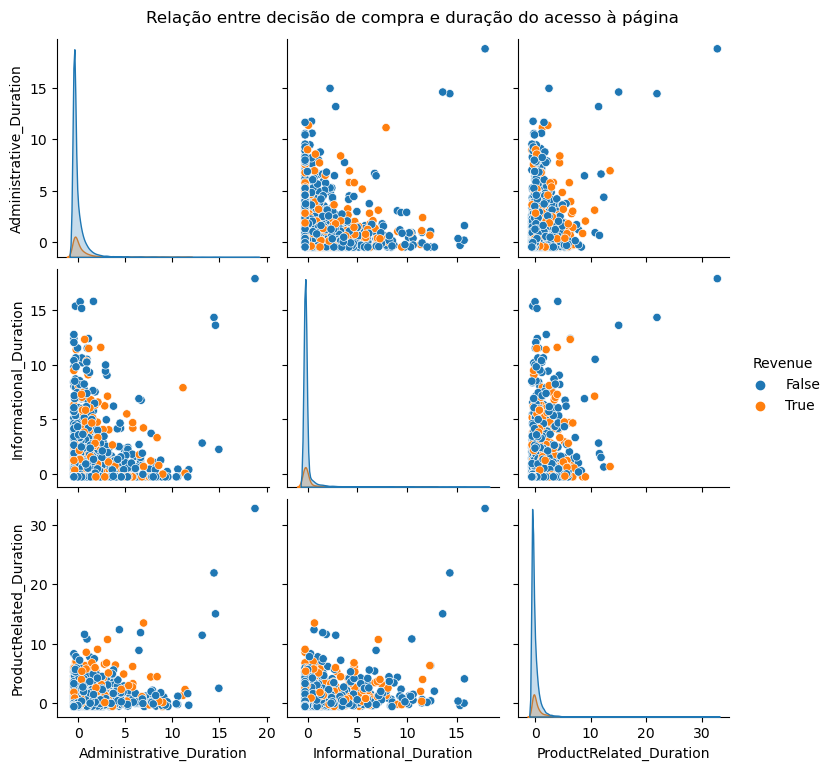

In [8]:
sns.pairplot(X_pad[['Administrative_Duration','Informational_Duration','ProductRelated_Duration','Revenue']], hue='Revenue')
plt.suptitle("Relação entre decisão de compra e duração do acesso à página", y=1.02,fontsize=12);

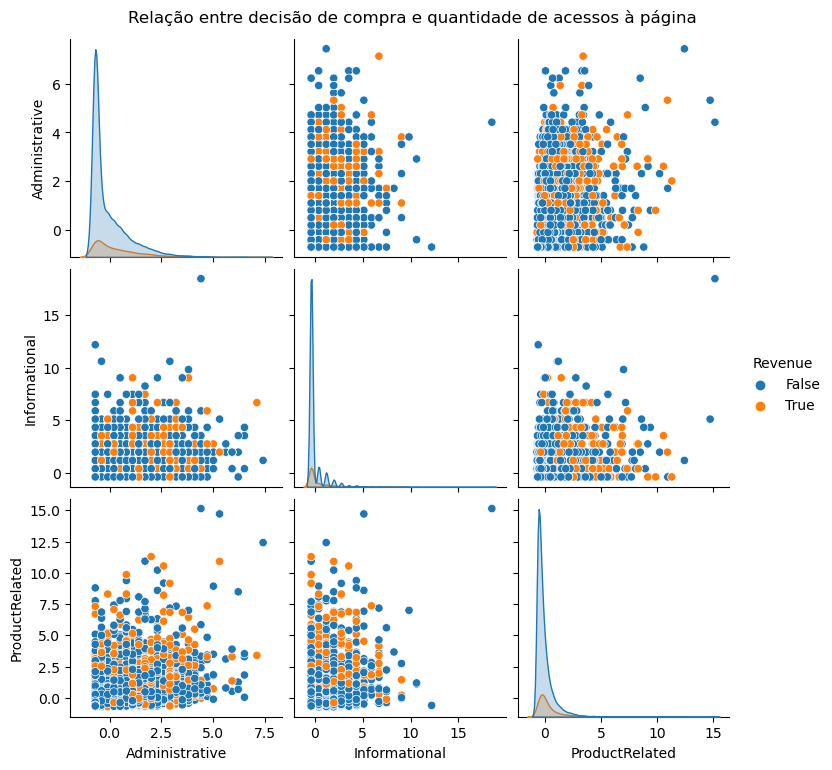

In [9]:
sns.pairplot(X_pad[['Administrative','Informational','ProductRelated','Revenue']], hue='Revenue')
plt.suptitle("Relação entre decisão de compra e quantidade de acessos à página",y=1.02, fontsize=12);

## Número de grupos

Utilize as técnicas vistas em aula que te ajudem a decidir pelo número de grupos a ser utilizados.

### Seleção de variáveis pelo método k-means

In [10]:
std_por_grupo = X_pad.groupby('Revenue').std()
med_por_grupo = X_pad.groupby('Revenue').median()
colunas_med = med_por_grupo.abs().idxmax(axis=1).values.tolist()
colunas_std = std_por_grupo.abs().idxmax(axis=1).values.tolist()

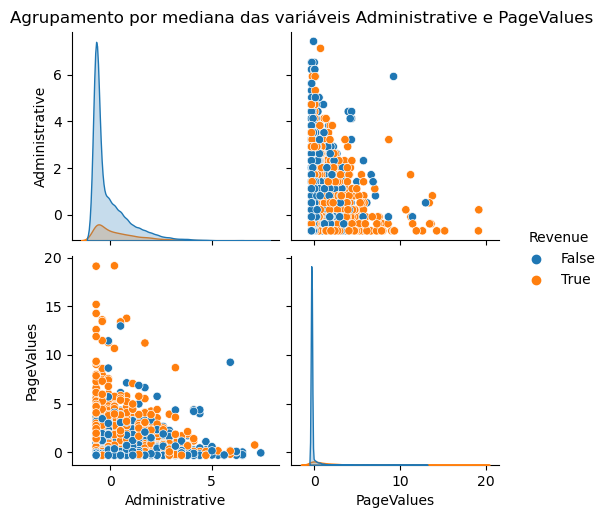

In [11]:
sns.pairplot(X_pad[colunas_med+['Revenue']], hue='Revenue')
plt.suptitle(f"Agrupamento por mediana das variáveis {colunas_med[0]} e {colunas_med[1]} ", y=1.02, fontsize=12);

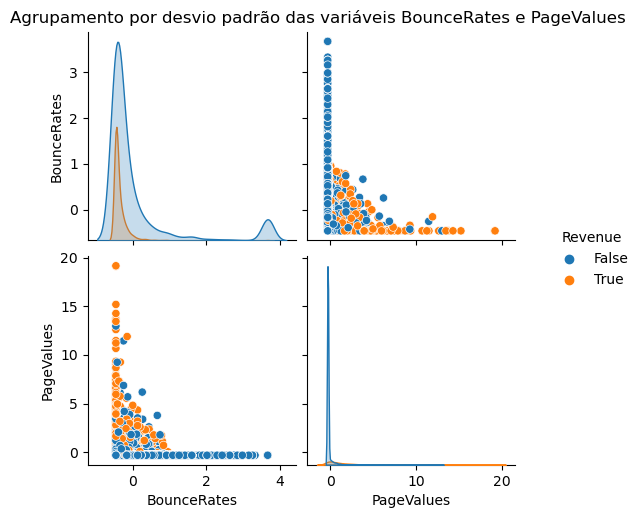

In [12]:
sns.pairplot(X_pad[colunas_std+['Revenue']], hue='Revenue')
plt.suptitle(f"Agrupamento por desvio padrão das variáveis {colunas_std[0]} e {colunas_std[1]} ", y=1.02, fontsize=12);

Número de grupos para cálculo: 4
Variáveis baseadas em (1) mediana ou (2) desvio padrão: 1


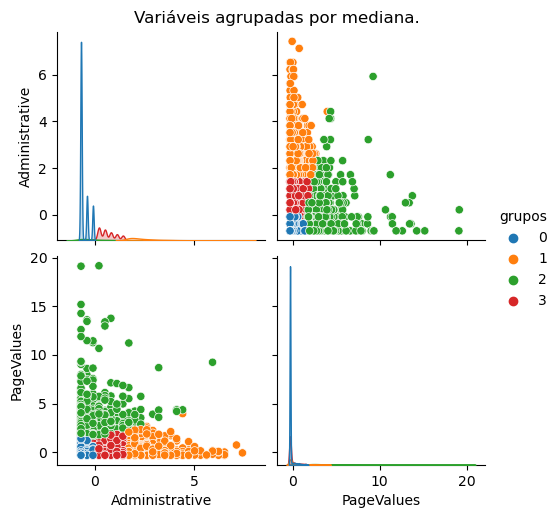

In [34]:
# Aplicando k-means
n=int(input(f'Número de grupos para cálculo: '))
c=int(input(f'Variáveis baseadas em (1) mediana ou (2) desvio padrão: '))

if c == 1:
    colunas = colunas_med
    tipo='mediana'
elif c == 2:
    colunas = colunas_std
    tipo='desvio padrão'
else:
    print('Opção incorreta!')
    
cluster = KMeans(n_clusters=n)
cluster.fit_predict(X_pad[colunas])    
X_pad['grupos'] = pd.Categorical(cluster.labels_)
colunas_ = list(colunas) + ['grupos']

sns.pairplot(X_pad[colunas_], hue='grupos')
plt.suptitle(f"Variáveis agrupadas por {tipo}.", y=1.02, fontsize=12);

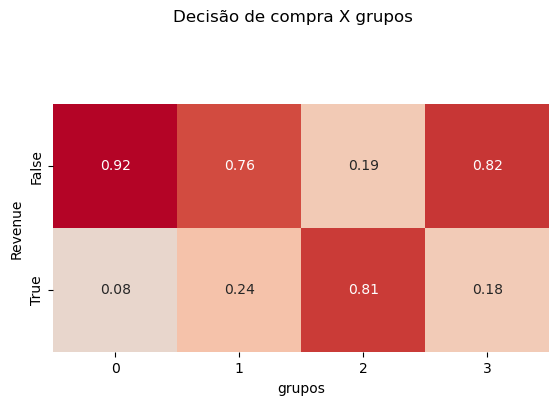

In [39]:
ct=pd.crosstab(X_pad.Revenue, X_pad.grupos,normalize='columns')
sns.heatmap(ct, cmap="coolwarm", annot=True, fmt='.2f',cbar=False,square=True,center=False)
plt.suptitle(f"Decisão de compra X grupos", y=.95, fontsize=12);

Escolha uma variável de 0 a 1: 1


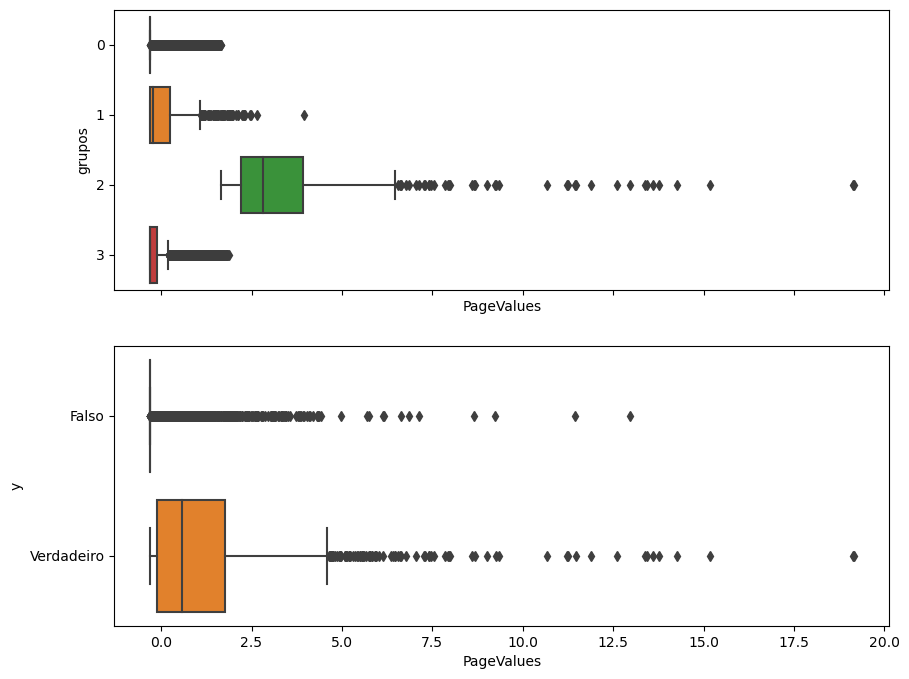

In [40]:
n = int(input(f'Escolha uma variável de 0 a {len(colunas)-1}: '))
X_pad['y'] =  np.where(X_pad['Revenue'], 'Verdadeiro', 'Falso')
def dataviz_grupos(varx):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

    sns.boxplot(data=X_pad, y='grupos', x=varx, ax=ax[0])
    sns.boxplot(data=X_pad, y='y', x=varx, ax=ax[1])
    plt.show()

dataviz_grupos(colunas[n])

## Avaliação dos grupos

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

### Análise do número de grupos pelo método do "cotovelo"

  0%|          | 0/14 [00:00<?, ?it/s]

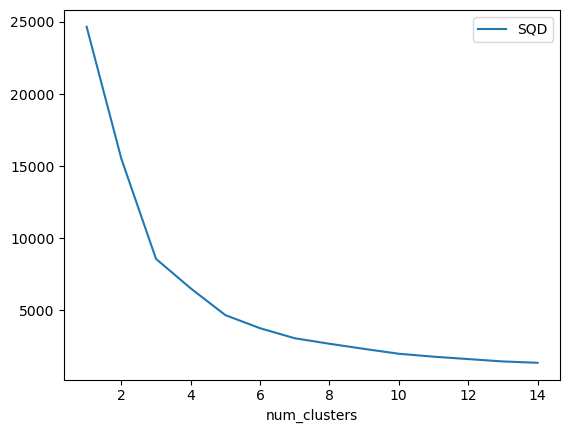

In [22]:
variaveis = colunas
SQD = []
K = range(1,15)
for k in tqdm(K):
    km = KMeans(n_clusters=k)
    km = km.fit(X_pad[variaveis])
    SQD.append(km.inertia_)

df_sqd = pd.DataFrame({'num_clusters': list(range(1, len(SQD)+1)), 'SQD': SQD})
df_sqd.plot(x = 'num_clusters', y = 'SQD');

### Análise do número de grupos pelo coeficiente da silhueta

Informe o número máximo de clusters: 8


  0%|          | 0/7 [00:00<?, ?it/s]

Número ideal de clusters indicado = 4


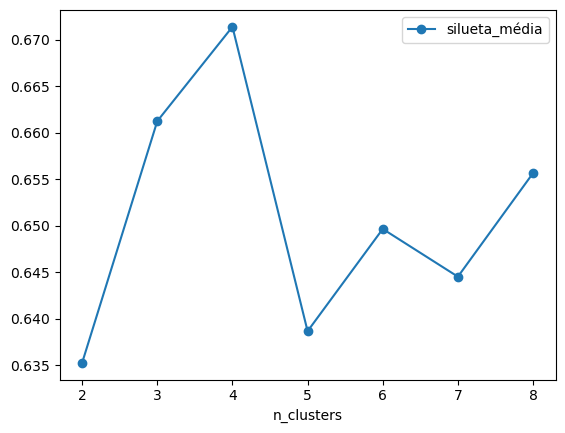

In [23]:
n = int(input(f'Informe o número máximo de clusters: '))
# Inicializar uma lista vazia que vai conter os valores da silueta média
        
siluetas = []
# Este é o número máximo de grupos que vamos testar
max_clusters = n

# O loop percorre de 2 até o máximo de clusters
for n_clusters in tqdm(range(2, max_clusters+1)):
    # Aqui rodamos o k-means
    km = KMeans(n_clusters=n_clusters).fit(X_pad[variaveis])
    # Aqui calculamos a silueta e guardamos o resultado na lista 'siluetas'
    siluetas.append(silhouette_score(X_pad[variaveis], km.labels_))
    # Essa list comprehendion define o nome dos grupos
    nomes_grupos = ['grupo_' + str(g) for g in range(n_clusters)]
    # Agora vamos adicionar uma coluna no dataframe X_pad com o agrupamento construido
    X_pad['grupos_'+str(n_clusters)] = pd.Categorical.from_codes(km.labels_, categories = nomes_grupos)


df_silueta = pd.DataFrame({'n_clusters': list(range(2, max_clusters+1)), 'silueta_média': siluetas})

df_silueta.plot.line(x = 'n_clusters', y = 'silueta_média', marker='o');
# plt.scatter(x = df_silueta.n_clusters, y = df_silueta.silueta_média)

max_silueta = df_silueta['silueta_média'].max()
idx = df_silueta['silueta_média'].idxmax()
n_cluster = df_silueta.loc[idx, 'n_clusters']

print(f'\033[1mNúmero ideal de clusters indicado = {n_cluster}\033[0m')


## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

Escolha uma variável de 0 a 13: 6


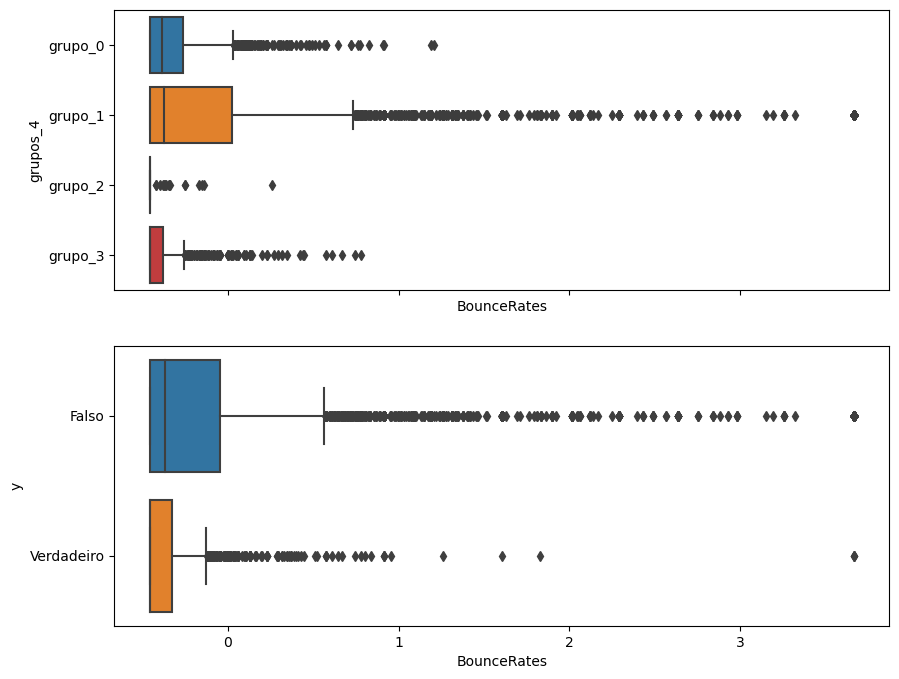

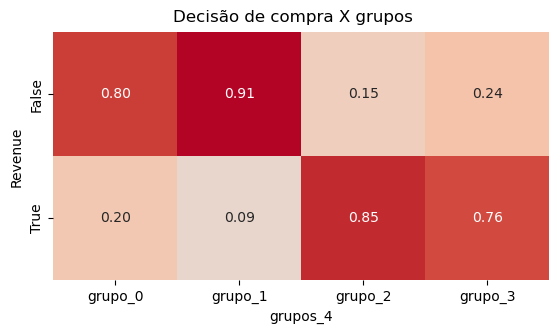

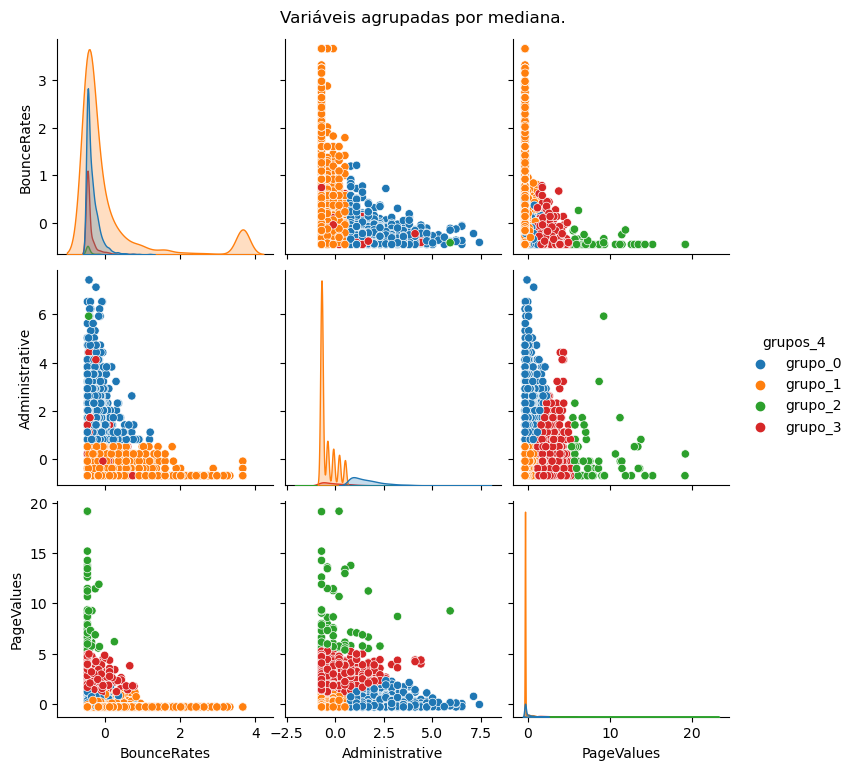

In [67]:
grupos=str('grupos'+'_'+str(n_cluster))
colunas_df = X_pad.select_dtypes(include="number").columns.to_list()

n = int(input(f'Escolha uma variável de 0 a {len(colunas_df)-1}: '))
def dataviz_grupos2(varx):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

    sns.boxplot(data=X_pad, y=grupos, x=varx, ax=ax[0])
    sns.boxplot(data=X_pad, y='y', x=varx, ax=ax[1])
    plt.show()

dataviz_grupos2(colunas_df[n])

ct=pd.crosstab(X_pad.Revenue, X_pad[grupos],normalize='columns')


sns.heatmap(ct, cmap="coolwarm", annot=True, fmt='.2f',cbar=False,square=True,center=False)
plt.suptitle(f"Decisão de compra X grupos", y=.8, fontsize=12);

sns.pairplot(X_pad[[colunas_df[n],'Administrative','PageValues','grupos_4']], hue='grupos_4')
plt.suptitle(f"Variáveis agrupadas por {tipo}.", y=1.02, fontsize=12);